In [ ]:
#default_exp data

# Audio Data
> Data representation and transformations for tests.

In [ ]:
#export
from fastai2.basics import *
import librosa
import librosa.display
import IPython
import numpy as np

In [ ]:
file = '/home/cerberus/Music/'

# Data

## Array Types

In [ ]:
#export
class ArraySpec(ndarray):
    #TODO Inherite from ArrayImage
    _show_args = {'cmap':'gist_gray', 'x_axis':'s', 'y_axis':'linear'}
    sr = 22050
    def __new__(cls, x, *args, **kwargs):
        if isinstance(x,tuple): super().__new__(cls, x, *args, **kwargs)
        if not isinstance(x,ndarray): x = array(x, np.float64)
        return x.view(cls)
    
    def show(self, ctx=None, figsize=None, **kwargs):
        return librosa.display.specshow(abs(self), **{**self._show_args, **kwargs})

In [ ]:
#export
class ArraySignal(ndarray):
    _show_args = {'x_axis':'s'}
    sr = 22050
    def __new__(cls, x, *args, **kwargs):
        if isinstance(x,tuple): super().__new__(cls, x, *args, **kwargs)
        if not isinstance(x,ndarray): x = array(x, np.float64)
        return x.view(cls)
    
    def show(self, ctx=None, figsize=None, **kwargs):
        librosa.display.waveplot(self, **{**self._show_args, **kwargs})
        return IPython.display.Audio(self, rate=self.sr)

## Tensor Types

In [ ]:
#export
class TensorSpec(Tensor):
    _show_args = ArraySpec._show_args
    sr = ArraySpec.sr
    def show(self, ctx=None, figsize=None, **kwargs):
        data = self.cpu().numpy()
        return librosa.display.specshow(abs(data), **{**self._show_args, **kwargs})

In [ ]:
#export
class TensorSignal(Tensor):
    _show_args = ArraySignal._show_args
    sr = ArraySpec.sr
    def show(self, sr=None, ctx=None, figsize=None, **kwargs):
        data = self.cpu().numpy()
        librosa.display.waveplot(abs(data), **{**self._show_args, **kwargs})
        return IPython.display.Audio(data, rate=ifnone(sr, self.sr))

## Data Transforms

In [ ]:
#export
ArraySpec._tensor_cls = TensorSpec
ArraySignal._tensor_cls = TensorSignal

In [ ]:
#export
@ToTensor
def encodes(self, o:ArraySpec): return ArraySpec._tensor_cls(abs(o))

@ToTensor
def encodes(self, o:ArraySignal): return ArraySignal._tensor_cls(o)

In [ ]:
#export
audio_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('audio/'))
def get_audio_files(path, recurse=True, folders=None):
    "Get image files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=audio_extensions, recurse=recurse, folders=folders)

In [ ]:
#export
class Spectify(Transform):
    #TODO Allow parameter changes
    def __init__(self, func=librosa.stft, **kwargs):
        self.transform = partial(func, **kwargs)
    def encodes(self, file:(str, Path)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            audio, _ = librosa.load(file, ArraySpec.sr)
        return ArraySpec(self.transform(audio))
    def encodes(self, audio:ndarray):
        return ArraySpec(self.transform(audio))

In [ ]:
#export
class AudioLoader(Transform):
    @delegates(librosa.load)
    def __init__(self, **kwargs):
        store_attr(self, 'kwargs')
    def encodes(self, file:(str, Path)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            y, _ = librosa.load(file, ArraySignal.sr, **self.kwargs)
        return ArraySignal(y)
    def encodes(self, audio:ndarray):
        return ArraySignal(audio)

## Data Blocks

In [ ]:
#export
def SpecBlock(spec_func=librosa.stft, **kwargs):
    return TransformBlock(type_tfms=Spectify(spec_func, **kwargs))

def SignalBlock(**kwargs):
    return TransformBlock(type_tfms=AudioLoader(**kwargs))

# Transforms

In [ ]:
#export
class Clipper(Transform):
    def __init__(self, segment_length):
        store_attr(self, 'segment_length')
    def encodes(self, audio:ArraySignal):
        if audio.size >= self.segment_length:
            max_audio_start = audio.size - self.segment_length
            audio_start = random.randint(0, max_audio_start)
            audio = audio[audio_start:audio_start+self.segment_length]
        else:
            audio = np.pad(audio, (0, self.segment_length - audio.size), 'constant')
        return audio

# DataBlock Example

In [ ]:
data = DataBlock((SpecBlock(librosa.stft), SignalBlock()),
                 get_items=get_audio_files,
                 get_x = Pipeline([AudioLoader(), Clipper(110250)]),
                 get_y = Pipeline([AudioLoader(), Clipper(110250)]),
                 splitter=RandomSplitter())
dls = data.dataloaders(file, bs=1)

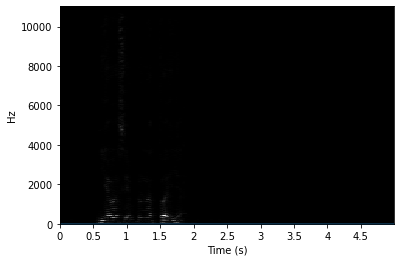

In [ ]:
dls.show_batch()

# Export

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script(fname="Data.ipynb")

Converted Data.ipynb.
